In [10]:
import numpy as np
import pandas as pd
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from matplotlib import pyplot as plt
from numpy.random import seed

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
df = pd.read_csv("dataAirbnb.csv")

In [4]:
df.drop(labels=['Airbnb Property ID','Occupancy Rate LTM','Days on Platform', 'Year'], axis=1)

,Annual Revenue LTM (USD),Number of Bookings LTM,Number of Reviews,Bedrooms,Bathrooms,Max Guests,Response Rate,Airbnb Superhost,Cancellation Policy,Cleaning Fee (USD),Published Nightly Rate (USD),Minimum Stay,Count Reservation Days LTM,Number of Photos,Instantbook Enabled,Overall Rating,Airbnb Accuracy Rating,Pets Allowed,Days on AirBNB,Occupancy Rate
0,930.0,1.0,167.0,3.0,2.0,8.0,90.0,False,strict_14_with_grace_period,100.0,140.0,2.0,4.0,25.0,False,92.0,9.0,False,2103,0
1,1684.0,3.0,71.0,1.0,1.5,1.0,100.0,False,moderate,30.0,54.0,21.0,42.0,20.0,False,97.0,10.0,False,2101,0
2,3365.0,1.0,5.0,2.0,2.0,6.0,90.0,False,moderate,250.0,445.0,2.0,7.0,18.0,False,92.0,9.0,False,2100,0
3,344.0,2.0,133.0,0.0,1.0,2.0,100.0,False,strict_14_with_grace_period,25.0,49.0,1.0,6.0,16.0,False,92.0,9.0,False,2099,0
4,845.0,2.0,49.0,3.0,2.0,8.0,100.0,False,strict_14_with_grace_period,75.0,139.0,2.0,5.0,49.0,False,88.0,9.0,False,2099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63799,486.0,0.0,4.0,2.0,2.0,6.0,0.0,False,moderate,99.0,199.0,1.0,3.0,17.0,False,65.0,7.0,True,0,0
63800,2985.0,3.0,1.0,2.0,2.5,4.0,100.0,False,moderate,70.0,75.0,1.0,37.0,14.0,True,100.0,10.0,True,0,1
63801,2240.0,3.0,4.0,1.0,1.5,2.0,100.0,False,moderate,50.0,55.0,1.0,38.0,13.0,True,100.0,10.0,True,0,1
63802,260.0,0.0,5.0,1.0,1.5,4.0,100.0,False,strict_14_with_grace_period,50.0,80.0,1.0,3.0,11.0,False,68.0,8.0,False,0,0


In [5]:
X_cols = ['Annual Revenue LTM (USD)','Number of Bookings LTM', 'Number of Reviews', 'Bedrooms', 'Bathrooms',
       'Max Guests', 'Response Rate','Cleaning Fee (USD)','Published Nightly Rate (USD)', 'Minimum Stay',
       'Count Reservation Days LTM', 'Number of Photos','Overall Rating', 'Airbnb Accuracy Rating','Days on AirBNB',
            'Airbnb Superhost','Cancellation Policy','Instantbook Enabled','Pets Allowed']

Y_cols = ['Occupancy Rate']

In [6]:
X_data = df[X_cols].copy()
Y_data = df[Y_cols].copy()

In [7]:
X_data = pd.get_dummies(X_data, columns=['Airbnb Superhost','Cancellation Policy','Instantbook Enabled',
                                        'Pets Allowed'], drop_first=True)

In [8]:
X_data = np.array(X_data)
y_data = np.array(Y_data)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,random_state=1, test_size=0.2)

In [12]:
# Instantiate encoder/scaler
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

# Decision Trees

In [13]:
clf_dT = DecisionTreeClassifier(ccp_alpha=0.001, criterion='gini', class_weight = {0:1, 1:1})
clf_dT.fit(X_train, y_train.ravel())

DecisionTreeClassifier(ccp_alpha=0.001, class_weight={0: 1, 1: 1})

In [14]:
dT_train_predict = clf_dT.predict(X_train)

In [15]:
print("f1_score on the training set: %f" % f1_score(y_train, dT_train_predict, average="weighted"))

f1_score on the training set: 0.771240


In [16]:
#COmputing mean of the five fold cross validation score
sc = cross_val_score(clf_dT, X_train, y_train,scoring="f1_weighted", cv=5)
print("Cross Validation scores: ", sc)
print("Cross Validation scores mean: ", sc.mean())

Cross Validation scores:  [0.7661686  0.76534991 0.76998173 0.77151095 0.76070381]
Cross Validation scores mean:  0.766743002175142


In [17]:
def plot_learning_curve(estimator,title,X,y,axes=None,ylim=None,cv=None,n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5),):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,
        train_sizes=train_sizes,scoring="f1_micro",return_times=True,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [18]:
param_grid_decision = { 
    'max_depth': [2, 4],              
    'ccp_alpha': [0.01, 0.008, 0.006, 0.005]
}

estimator = DecisionTreeClassifier(class_weight = {0:1, 1:1}, criterion='gini')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid_decision, 
                           cv = 5, n_jobs = -1, verbose = 1, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

#First grid search
grid1 = grid_search.best_estimator_
f1_score1 = grid_search.best_score_
print("Best estimator: ", grid1)
print("\n")
print("Best f1 score: ", f1_score1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.005, class_weight={0: 1, 1: 1}, max_depth=4)


Best f1 score:  0.7520687937492498


In [19]:
param_grid_decision = {              
    'max_features': [2, 4],
    'ccp_alpha': [0.005, 0.002, 0.001]
}

estimator = DecisionTreeClassifier(class_weight = {0:1, 1:1}, criterion='gini', max_depth=4)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid_decision, 
                           cv = 5, n_jobs = -1, verbose = 1, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

#Second grid search
grid2 = grid_search.best_estimator_
f1_score2 = grid_search.best_score_
print("Best estimator: ", grid2)
print("\n")
print("Best f1 score: ", f1_score2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.002, class_weight={0: 1, 1: 1}, max_depth=4,
                       max_features=2)


Best f1 score:  0.7224367349794183


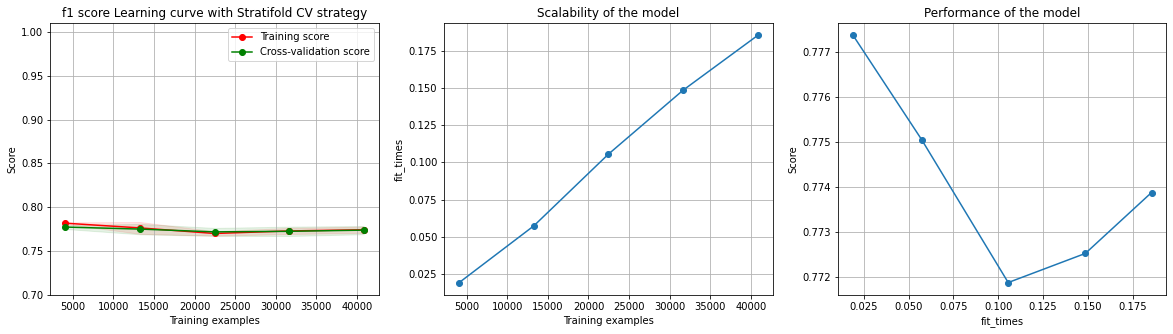

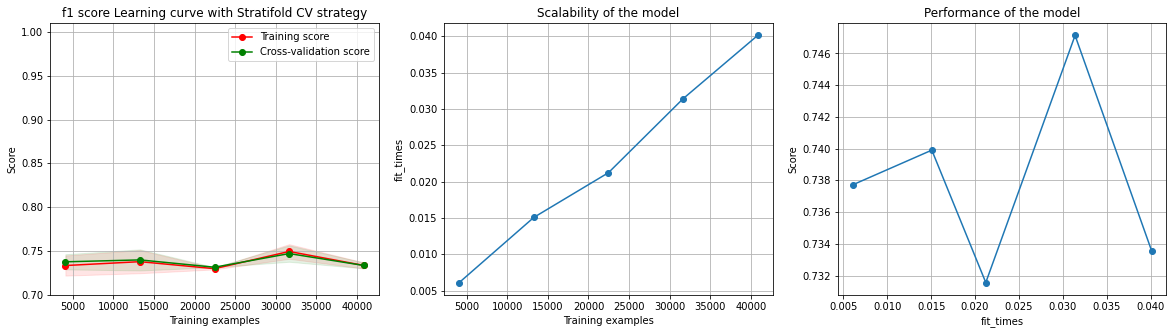

In [21]:
estimators = [grid1, grid2]
for estimator in estimators:
    
    #Shuffle Split = Stratifold strategy
    title1 = "f1 score Learning curve with Stratifold CV strategy"
    plot_learning_curve(estimator, title1, X_train, y_train, axes=None, ylim=(0.7, 1.01),
                    cv=None, n_jobs=-1)

In [23]:
def complexity_curve(train_scores, validation_scores, index, title, inverse_x=False):
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(index, train_scores , "r-+",label="Train")
    plt.plot(index, test_scores, "g-+",label="Validation")
    plt.title(title)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    #plt.gca().invert_xaxis()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished


[0.76761786 0.75256292 0.75093716 0.74709787 0.61814739] [0.766743   0.75206879 0.75015635 0.74549505 0.61814739] [0.001, 0.005, 0.01, 0.05, 0.1]


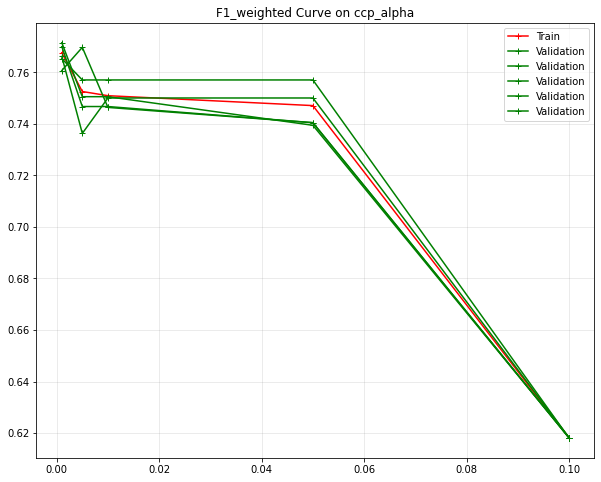

In [24]:
#Using the validation curve determine the best alpha
param_range = [0.001, 0.005, 0.01, 0.05, 0.1]
train_scores, test_scores = validation_curve(DecisionTreeClassifier(), X_train, y_train, param_name="ccp_alpha", 
    param_range=param_range, scoring='f1_weighted', verbose=1, cv=5, n_jobs=-1)
print(train_scores.mean(axis=1), test_scores.mean(axis=1), param_range)
complexity_curve(train_scores.mean(axis=1), test_scores.mean(axis=1), param_range, 
                title='F1_weighted Curve on ccp_alpha')

Best alpha parameter:  0.001


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

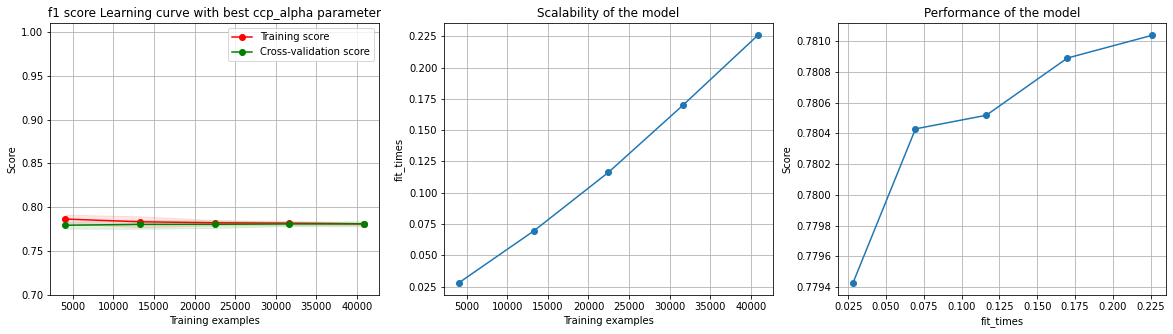

In [25]:
#Determining the best ccp_alpha value
n = test_scores.mean(axis=1).argmax()
optimal_ccp_alpha = param_range[n]
print("Best alpha parameter: ", optimal_ccp_alpha)
clf_dT = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, class_weight={0: 1, 1: 1.1},max_depth=4)


#Shuffle Split with Stratified strategy
title2 = "f1 score Learning curve with best ccp_alpha parameter"
cv_dT= ShuffleSplit(test_size=0.2, random_state=0)
plot_learning_curve(clf_dT, title2, X_train, y_train, axes=None, ylim=(0.7, 1.01),
                cv=cv_dT, n_jobs=-1)

In [26]:
clf_dT.fit(X_train, y_train)
predict_decision = clf_dT.predict(X_test)


#Print results
print(classification_report(y_test, predict_decision))
print("f1 score: ", f1_score(y_test, predict_decision, average="weighted"))
print()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predict_decision).flatten()
type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100
print("True Negative, False Positive, False Negative, True Positive: ", tn_test, fp_test, fn_test, tp_test)
print()
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)
print()
      
probs_dc = clf_dT.predict_proba(X_test)
probs_dc = probs_dc[:, 1]
auc = roc_auc_score(y_test, probs_dc)
print('AUC: %.3f' % auc)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      9269
           1       0.63      0.48      0.54      3492

    accuracy                           0.78     12761
   macro avg       0.72      0.69      0.70     12761
weighted avg       0.77      0.78      0.77     12761

f1 score:  0.7692492914069181

True Negative, False Positive, False Negative, True Positive:  8280 989 1825 1667

Type I error:  52.26231386025199
Type II error:  10.66997518610422

AUC: 0.770
